<font size=5 face="微软雅黑">**天猫复购预测之挑战**</font>

<h1><center>天猫复购预测之挑战</center></h1>

<h1>目录</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#数据预处理">数据预处理</a></li>
        <li><a href="#数据分析">数据分析</a></li>
        <li><a href="#3">3</a></li>
        <li><a href="#4">4</a></li>
    </ol>
</div>
<br>
<hr>

# 数据预处理

In [2]:
# 导入数据包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl
import seaborn as sns

import random
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor

In [4]:
# 导入数据
df_user_info = pd.read_csv('user_info_format1.csv')
df_user_log = pd.read_csv('user_log_format1.csv')
df_test = pd.read_csv('test_format1.csv')
df_train = pd.read_csv('train_format1.csv')

## 消费者特征

### 用户基本数据

In [7]:
# 查看数据
df_user_info_copy = df_user_info
df_user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [28]:
df_user_info = df_user_info_copy

In [29]:
# 查看是否有缺失值
df_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  424170 non-null  float64
 2   gender     424170 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [30]:
# 填补缺失值
df_user_info.age_range.fillna(df_user_info.age_range.median(),inplace=True) #年龄用中位数填充
df_user_info.gender.fillna(df_user_info.gender.mode()[0],inplace=True) #性别用众数填充
np.sum(df_user_info.isnull()) #检查还有无缺失值

user_id      0
age_range    0
gender       0
dtype: int64

In [31]:
# 变量处理
df_age = pd.get_dummies(df_user_info.age_range,prefix='age') #对年龄进行编码处理
df_gender = pd.get_dummies(df_user_info.gender) #对性别进行one-hot编码
df_gender.rename(columns={0:"female",1:"male",2:"unknown"},inplace=True) #更改df_gender列名
df_user_info = pd.concat([df_user_info.user_id,df_age,df_gender],axis=1) #将处理过的变量合并
del df_age,df_gender #删除处理变量
df_user_info.head() #查看数据

,user_id,age_0.0,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,female,male,unknown
0,376517,0,0,0,0,0,0,1,0,0,0,1,0
1,234512,0,0,0,0,0,1,0,0,0,1,0,0
2,344532,0,0,0,0,0,1,0,0,0,1,0,0
3,186135,0,0,0,0,0,1,0,0,0,1,0,0
4,30230,0,0,0,0,0,1,0,0,0,1,0,0


### 用户分析日志数据

In [38]:
# 查看数据
df_user_log_copy = df_user_log
df_user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [47]:
# 变量处理
# 提取用户全部的原始行为数据
df_total_actions = df_user_log[["user_id","action_type"]]

# 对行为数据进行编码：0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹
df_action = pd.get_dummies(df_total_actions.action_type,prefix='TotalActions')

df_total_actions = pd.concat([df_total_actions.user_id,df_action], \
                             axis=1).groupby(["user_id"],as_index=False).sum() #将处理过的变量合并
del df_action #删除处理变量
df_total_actions.head() #查看数据

,user_id,TotalActions_0,TotalActions_1,TotalActions_2,TotalActions_3
0,1,27.0,0.0,6.0,0.0
1,2,47.0,0.0,14.0,2.0
2,3,63.0,0.0,4.0,1.0
3,4,49.0,0.0,1.0,0.0
4,5,150.0,0.0,13.0,10.0


# 数据分析

## 消费者特征

In [48]:
# 统计点击、加入、购买、收藏的总次数
df_total_actions["User_TotalActions"] = df_total_actions["TotalActions_0"]\
+ df_total_actions["TotalActions_1"] + df_total_actions["TotalActions_2"]\
+ df_total_actions["TotalActions_3"]

In [54]:
print("所有用户交互次数"+ str(df_user_log.shape[0]))
print("所有用户数" + str(df_user_log["user_id"].nunique()))
print("所有用户平均交互次数"+ str(df_user_log.shape[0]/df_user_log["user_id"].nunique()))
df_total_actions["user_totalactions_ratio"] = df_total_actions["User_TotalActions"]/df_user_log.shape[0]
df_total_actions["user_totalactions_diff"] = df_total_actions["User_TotalActions"]\
-df_user_log.shape[0]/df_user_log["user_id"].nunique()

所有用户交互次数54925330
所有用户数424170
所有用户平均交互次数129.48895490015795


ValueError: shape mismatch: objects cannot be broadcast to a single shape

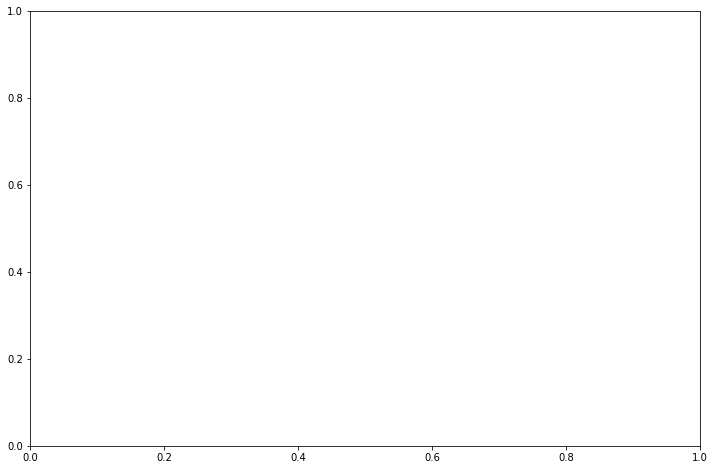

In [56]:
user_plot = [df_user_log.shape[0],df_user_log["user_id"].nunique(),]
fig=plt.figure(figsize=(12,8)) # define plot area
plt.bar(df_user_log["user_id"], df_total_actions["User_TotalActions"], color='lightblue')
ax = fig.gca() # define axis    
ax.set_title('Action')  # Give the plot a main title
ax.set_xlabel('user_id') # Set the label for the x axis
ax.set_ylabel('User_TotalActions') # Set the label for the y axis
ax.legend() #include legends
plt.ylim(0,0.30) #range of the y axis
plt.show()